The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0


# Hyperparameter Optimization API
:label:`sec_api_hpo`

Before we dive into the methodology, we will first discuss a basic code
structure that allows us to efficiently implement various HPO algorithms. In
general, all HPO algorithms considered here need to implement two decision
making primitives, *searching* and *scheduling*. First, they need to sample new
hyperparameter configurations, which often involves some kind of search over the
configuration space. Second, for each configuration, an HPO algorithm needs to
schedule its evaluation and decide how many resources to allocate for it. Once
we start to evaluate a configuration, we will refer to it as a *trial*. We map
these decisions to two classes, `HPOSearcher` and `HPOScheduler`. On top of that,
we also provide a `HPOTuner` class that executes the optimization process.

This concept of scheduler and searcher is also implemented in popular HPO
libraries, such as Syne Tune :cite:`salinas-automl22`, Ray Tune
:cite:`liaw-arxiv18` or Optuna :cite:`akiba-sigkdd19`.


In [1]:
import time
from scipy import stats
from d2l import torch as d2l

## Searcher

Below we define a base class for searchers, which provides a new candidate
configuration through the `sample_configuration` function. A simple way to
implement this function would be to sample configurations uniformly at random,
as we did for random search in :numref:`sec_what_is_hpo`. More sophisticated
algorithms, such as Bayesian optimization, will make these
decisions based on the performance of previous trials. As a result, these
algorithms are able to sample more promising candidates over time. We add the
`update` function in order to update the history of previous trials, which can
then be exploited to improve our sampling distribution.


In [2]:
class HPOSearcher(d2l.HyperParameters):  #@save
    def sample_configuration() -> dict:
        raise NotImplementedError

    def update(self, config: dict, error: float, additional_info=None):
        pass

The following code shows how to implement our random search optimizer from the
previous section in this API. As a slight extension, we allow the user to
prescribe the first configuration to be evaluated via `initial_config`, while
subsequent ones are drawn at random.


In [3]:
class RandomSearcher(HPOSearcher):  #@save
    def __init__(self, config_space: dict, initial_config=None):
        self.save_hyperparameters()

    def sample_configuration(self) -> dict:
        if self.initial_config is not None:
            result = self.initial_config
            self.initial_config = None
        else:
            result = {
                name: domain.rvs()
                for name, domain in self.config_space.items()
            }
        return result

## Scheduler

Beyond sampling configurations for new trials, we also need to decide when and
for how long to run a trial. In practice, all these decisions are done by the
`HPOScheduler`, which delegates the choice of new configurations to a
`HPOSearcher`. The `suggest` method is called whenever some resource for training
becomes available. Apart from invoking `sample_configuration` of a searcher, it
may also decide upon parameters like `max_epochs` (i.e., how long to train the
model for). The `update` method is called whenever a trial returns a new
observation.


In [4]:
class HPOScheduler(d2l.HyperParameters):  #@save
    def suggest(self) -> dict:
        raise NotImplementedError

    def update(self, config: dict, error: float, info=None):
        raise NotImplementedError

To implement random search, but also other HPO algorithms, we only need a basic
scheduler that schedules a new configuration every time new resources become
available.


In [5]:
class BasicScheduler(HPOScheduler):  #@save
    def __init__(self, searcher: HPOSearcher):
        self.save_hyperparameters()

    def suggest(self) -> dict:
        return self.searcher.sample_configuration()

    def update(self, config: dict, error: float, info=None):
        self.searcher.update(config, error, additional_info=info)

## Tuner

Finally, we need a component that runs the scheduler/searcher and does some
book-keeping of the results. The following code implements a sequential
execution of the HPO trials that evaluates one training job after the next and
will serve as a basic example. We will later use *Syne Tune* for more scalable
distributed HPO cases.


In [6]:
class HPOTuner(d2l.HyperParameters):  #@save
    def __init__(self, scheduler: HPOScheduler, objective: callable):
        self.save_hyperparameters()
        # Bookeeping results for plotting
        self.incumbent = None
        self.incumbent_error = None
        self.incumbent_trajectory = []
        self.cumulative_runtime = []
        self.current_runtime = 0
        self.records = []

    def run(self, number_of_trials):
        for i in range(number_of_trials):
            start_time = time.time()
            config = self.scheduler.suggest()
            print(f"Trial {i}: config = {config}")
            error = self.objective(**config)
            error = float(error.cpu().detach().numpy())
            self.scheduler.update(config, error)
            runtime = time.time() - start_time
            self.bookkeeping(config, error, runtime)
            print(f"    error = {error}, runtime = {runtime}")

## Bookkeeping the Performance of HPO Algorithms

With any HPO algorithm, we are mostly interested in the best performing
configuration (called *incumbent*) and its validation error after a given 
wall-clock time. This is why we track `runtime` per iteration, which includes
both the time to run an evaluation (call of `objective`) and the time to
make a decision (call of `scheduler.suggest`). In the sequel, we will plot
`cumulative_runtime` against `incumbent_trajectory` in  order to visualize the
*any-time performance* of the HPO algorithm defined in  terms of `scheduler`
(and `searcher`). This allows us to quantify not only how well the configuration
found by an optimizer works, but also how quickly an optimizer is able to find it.


In [7]:
@d2l.add_to_class(HPOTuner)  #@save
def bookkeeping(self, config: dict, error: float, runtime: float):
    self.records.append({"config": config, "error": error, "runtime": runtime})
    # Check if the last hyperparameter configuration performs better
    # than the incumbent
    if self.incumbent is None or self.incumbent_error > error:
        self.incumbent = config
        self.incumbent_error = error
    # Add current best observed performance to the optimization trajectory
    self.incumbent_trajectory.append(self.incumbent_error)
    # Update runtime
    self.current_runtime += runtime
    self.cumulative_runtime.append(self.current_runtime)

## Example: Optimizing the Hyperparameters of a Convolutional Neural Network

We now use our new implementation of random search to optimize the
*batch size* and *learning rate* of the `LeNet` convolutional neural network
from :numref:`sec_lenet`. We being by defining the objective function, which
will once more be validation error.


In [8]:
def hpo_objective_lenet(learning_rate, batch_size, max_epochs=10):  #@save
    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=max_epochs, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    trainer.fit(model=model, data=data)
    validation_error = trainer.validation_error()
    return validation_error

We also need to define the configuration space. Moreover, the first configuration
to be evaluated is the default setting used in :numref:`sec_lenet`.


In [9]:
config_space = {
    "learning_rate": stats.loguniform(1e-2, 1),
    "batch_size": stats.randint(32, 256),
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

Now we can start our random search:


    error = 0.42863988876342773, runtime = 69.36778783798218


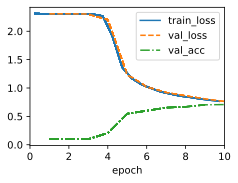

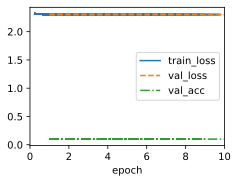

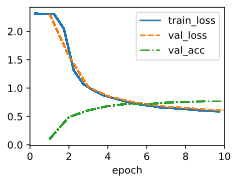

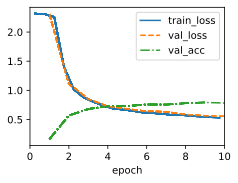

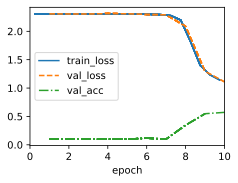

In [10]:
searcher = RandomSearcher(config_space, initial_config=initial_config)
scheduler = BasicScheduler(searcher=searcher)
tuner = HPOTuner(scheduler=scheduler, objective=hpo_objective_lenet)
tuner.run(number_of_trials=5)

Below we plot the optimization trajectory of the incumbent to get the any-time
performance of random search:


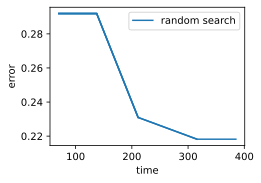

In [11]:
board = d2l.ProgressBoard(xlabel="time", ylabel="error")
for time_stamp, error in zip(
    tuner.cumulative_runtime, tuner.incumbent_trajectory
):
    board.draw(time_stamp, error, "random search", every_n=1)

## Comparing HPO Algorithms

Just as with training algorithms or model architectures, it is important to
understand how to best compare different HPO algorithms. Each HPO run depends
on two major sources of randomness: the random effects of the training process,
such as random weight initialization or mini-batch ordering, and the intrinsic
randomness of the HPO algorithm itself, such as the random sampling of random
search. Hence, when comparing different algorithms, it is crucial to run each
experiment several times and report statistics, such as mean or median, across
a population of multiple repetitions of an algorithm based on different seeds
of the random number generator.

To illustrate this, we compare random search (see :numref:`sec_rs`) and Bayesian
optimization :cite:`snoek-nips12` on tuning the hyperparameters of a feed-forward
neural network. Each algorithm was evaluated
$50$ times with a different random seed. The solid line indicates the average
performance of the incumbent across these $50$ repetitions and the dashed line
the standard deviation. We can see that random search and Bayesian optimization
perform roughly the same up to ~1000 seconds, but Bayesian optimization can
make use of the past observation to identify better configurations and thus
quickly outperforms random search afterwards.


![Example any-time performance plot to compare two algorithms A and B.](http://d2l.ai/_images/example_anytime_performance.svg)
:label:`example_anytime_performance`

## Summary

This section laid out a simple, yet flexible interface to implement various HPO
algorithms that we will look at in this chapter. Similar interfaces can be found
in popular open-source HPO frameworks. We also looked at how we can compare HPO
algorithms, and potential pitfall one needs to be aware. 

## Exercises

1. The goal of this exercise is to implement the objective function for a slightly more challenging HPO problem, and to run more realistic experiments. We will use the two hidden layer MLP `DropoutMLP` implemented in :numref:`sec_dropout`.
    1. Code up the objective function, which should depend on all hyperparameters of the model and `batch_size`. Use `max_epochs=50`. GPUs do not help here, so `num_gpus=0`. Hint: Modify `hpo_objective_lenet`.
    2. Choose a sensible search space, where `num_hiddens_1`, `num_hiddens_2` are integers in $[8, 1024]$, and dropout values lie in $[0, 0.95]$, while `batch_size` lies in $[16, 384]$. Provide code for `config_space`, using sensible distributions from `scipy.stats`.
    3. Run random search on this example with `number_of_trials=20` and plot the results. Make sure to first evaluate the default configuration of :numref:`sec_dropout`, which is `initial_config = {'num_hiddens_1': 256, 'num_hiddens_2': 256, 'dropout_1': 0.5, 'dropout_2': 0.5, 'lr': 0.1, 'batch_size': 256}`.
2. In this exercise, you will implement a new searcher (subclass of `HPOSearcher`) which makes decisions based on past data. It depends on parameters `probab_local`, `num_init_random`. Its `sample_configuration` method works as follows. For the first `num_init_random` calls, do the same as `RandomSearcher.sample_configuration`. Otherwise, with probability `1 - probab_local`, do the same as `RandomSearcher.sample_configuration`. Otherwise, pick the configuration which attained the smallest validation error so far, select one of its hyperparameters at random, and sample its value randomly like in `RandomSearcher.sample_configuration`, but leave all other values the same. Return this configuration, which is identical to the best configuration so far, except in this one hyperparameter.
    1. Code up this new `LocalSearcher`. Hint: Your searcher requires `config_space` as argument at construction. Feel free to use a member of type `RandomSearcher`. You will also have to implement the `update` method.
    2. Re-run the experiment from the previous exercise, but using your new searcher instead of `RandomSearcher`. Experiment with different values for `probab_local`, `num_init_random`. However, note that a proper comparison between different HPO methods requires repeating experiments several times, and ideally considering a number of benchmark tasks.


[Discussions](https://discuss.d2l.ai/t/12092)
